In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from datetime import date, datetime
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.style.use('seaborn-deep')

## Definition of censoring and death

Quitting is death, all else is censoring. This is different than the [original article](https://fivethirtyeight.com/features/two-years-in-turnover-in-trumps-cabinet-is-still-historically-high/)'s author's rules, who stated that switching roles _within_ a cabinent is an "event". 

In [2]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/cabinet-turnover/cabinet-turnover.csv",
                    na_values=['Still in office', '#VALUE!']
                    )
TODAY = datetime.today().date()

INAUG_DATES = {
    'Trump': date(2017, 1, 20),
    'Obama': date(2009, 1, 20),
    'Bush 43': date(2001, 1, 20),
    'Clinton': date(1993, 1, 20),
    'Bush 41': date(1989, 1, 20),
    'Reagan': date(1981, 1, 20),
    'Carter': date(1977, 1, 20)
}

presidential_terms = pd.DataFrame(list(INAUG_DATES.items()))
presidential_terms.columns = ['president', 'president_start_date']
presidential_terms['president_end_date'] = presidential_terms['president_start_date'].shift(1).fillna(TODAY)
presidential_terms

,president,president_start_date,president_end_date
0,Trump,2017-01-20,2019-03-05
1,Obama,2009-01-20,2017-01-20
2,Bush 43,2001-01-20,2009-01-20
3,Clinton,1993-01-20,2001-01-20
4,Bush 41,1989-01-20,1993-01-20
5,Reagan,1981-01-20,1989-01-20
6,Carter,1977-01-20,1981-01-20


In [3]:
def fill_end(series):
    end, president = series
    if pd.notnull(end) and end.endswith('admin'):
        next_pres ,_ = end.split(' ')
        if next_pres == 'Bush':
            next_pres = next_pres + ' 43' if president == 'Clinton' else next_pres + ' 41'
        return INAUG_DATES[next_pres].strftime('%m/%d/%y')
    else:
        return end
    
def fill_start(series):
    end, president = series
    if pd.notnull(end) and end.endswith('admin'):
        prev_pres ,_ = end.split(' ')
        if prev_pres == 'Bush':
            prev_pres = prev_pres + ' 43' if president == 'Obama' else prev_pres + ' 41'
        return INAUG_DATES[president].strftime('%m/%d/%y')
    else:
        return end
    
    
raw_df['end'] = raw_df[['end', 'president']].apply(fill_end, axis=1)
raw_df['start'] = raw_df[['start', 'president']].apply(fill_start, axis=1)

raw_df['end'] = pd.to_datetime(raw_df['end']).dt.date
raw_df['end'] = raw_df['end'].fillna(TODAY)
raw_df['start'] = pd.to_datetime(raw_df['start']).dt.date

In [4]:
raw_df = raw_df.merge(presidential_terms, left_on='president', right_on='president')
raw_df['event'] = (raw_df['end'] < raw_df['president_end_date']) & pd.notnull(raw_df['end'])


In [5]:
# we need to "collapse" individuals into rows, because they may change positions, but that's not quitting...
def collapse(df):
    return df.groupby('appointee', as_index=False).aggregate({
        'start': 'min', 'end': 'max', 'event': 'all', 'president': 'last', 'president_end_date': 'last'
    })

raw_df = raw_df.groupby('president', as_index=False).apply(collapse).reset_index(drop=True)
raw_df['T'] = (raw_df['end'] - raw_df['start']).dt.days


In [6]:
raw_df.tail(20)

,appointee,start,end,event,president,president_end_date,T
267,Jeff Sessions,2017-02-09,2018-11-07,True,Trump,2019-03-05,636
268,Jim Mattis,2017-01-20,2018-12-31,True,Trump,2019-03-05,710
269,John Kelly,2017-01-20,2018-12-31,True,Trump,2019-03-05,710
270,Kirstjen Nielsen,2017-12-06,2019-03-05,False,Trump,2019-03-05,454
271,Linda McMahon,2017-02-14,2019-03-05,False,Trump,2019-03-05,749
272,Mick Mulvaney,2017-02-16,2019-03-05,False,Trump,2019-03-05,747
273,Mike Pence,2017-01-20,2019-03-05,False,Trump,2019-03-05,774
274,Mike Pompeo,2017-01-23,2019-03-05,False,Trump,2019-03-05,771
275,Nikki Haley,2017-01-27,2018-12-31,True,Trump,2019-03-05,703
276,Reince Priebus,2017-01-20,2017-07-28,True,Trump,2019-03-05,189


<lifelines.PiecewiseExponentialFitter: fitted with 287 observations, 129 censored>
number of subjects = 287
  number of events = 158
    log-likelihood = -1310.480
        hypothesis = lambda_0_ != 1, lambda_1_ != 1, lambda_2_ != 1

---
               coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
lambda_0_ 2872.6704  280.8217   2322.2701   3423.0708 <5e-05   79.1248
lambda_1_  154.6505   30.4338     95.0013    214.2998 <5e-05   21.1000
lambda_2_ 1101.0836  189.0864    730.4810   1471.6862 <5e-05   27.3221


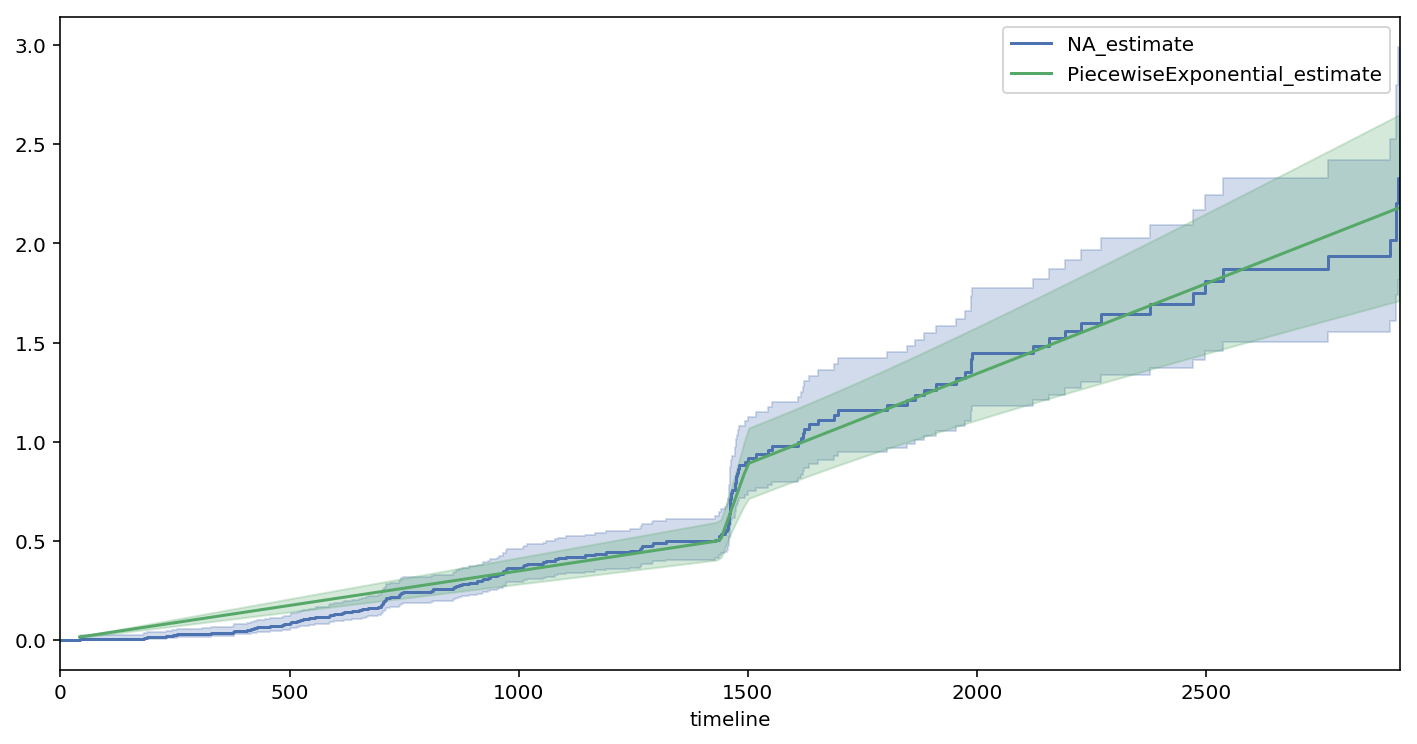

In [7]:
naf = NelsonAalenFitter()
ax = naf.fit(raw_df['T'],raw_df['event']).plot()

from lifelines import PiecewiseExponentialFitter
pf = PiecewiseExponentialFitter(breakpoints=[1440, 1500])
pf.fit(raw_df['T'], raw_df['event'])
pf.plot(ax=ax)
pf.print_summary(4)

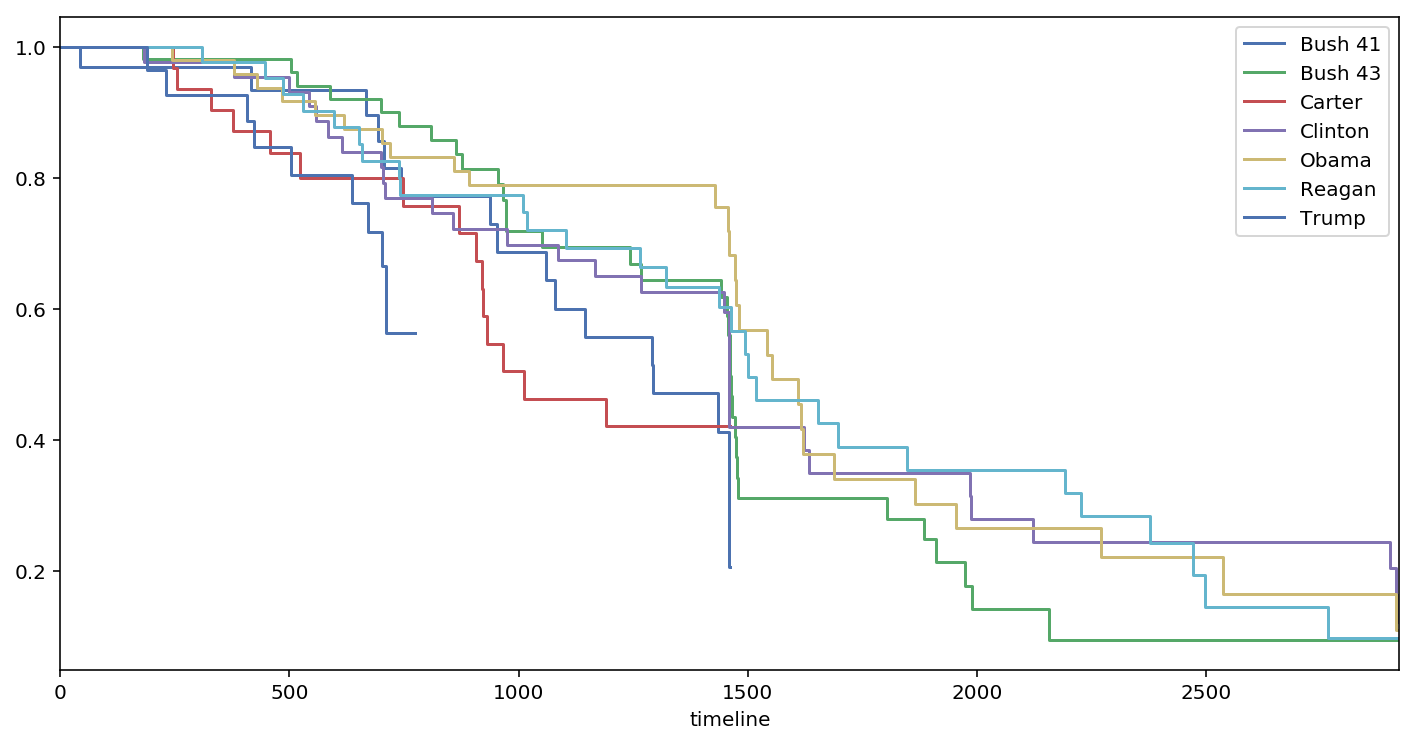

In [8]:
kmf = KaplanMeierFitter()

ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    kmf.fit(df_['T'], df_['event'], label=name)
    ax = kmf.plot(ax=ax, ci_show=False)


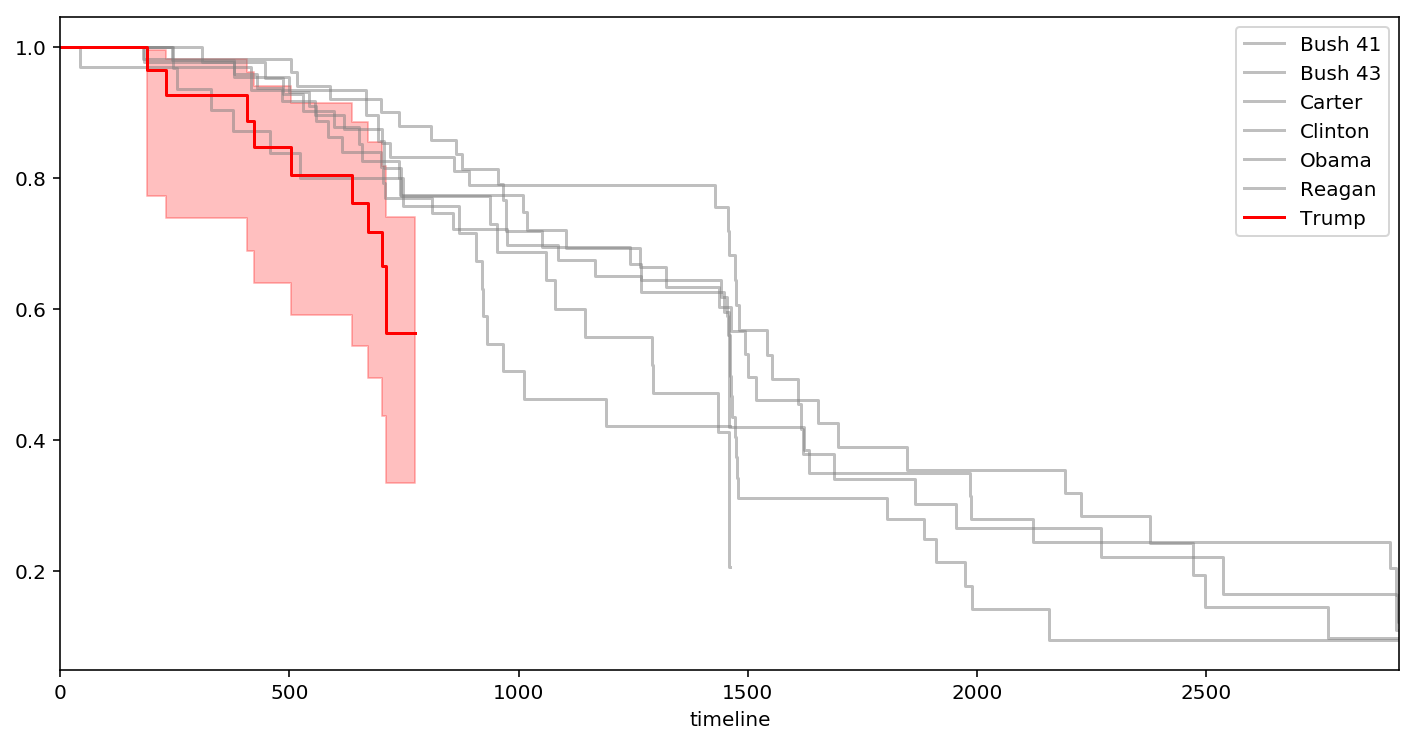

In [9]:
ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    kmf.fit(df_['T'], df_['event'], label=name)
    if name == 'Trump':
        ax = kmf.plot(ax=ax, c='r')
    else:
        ax = kmf.plot(ax=ax, c='grey', alpha=0.5, ci_show=False)


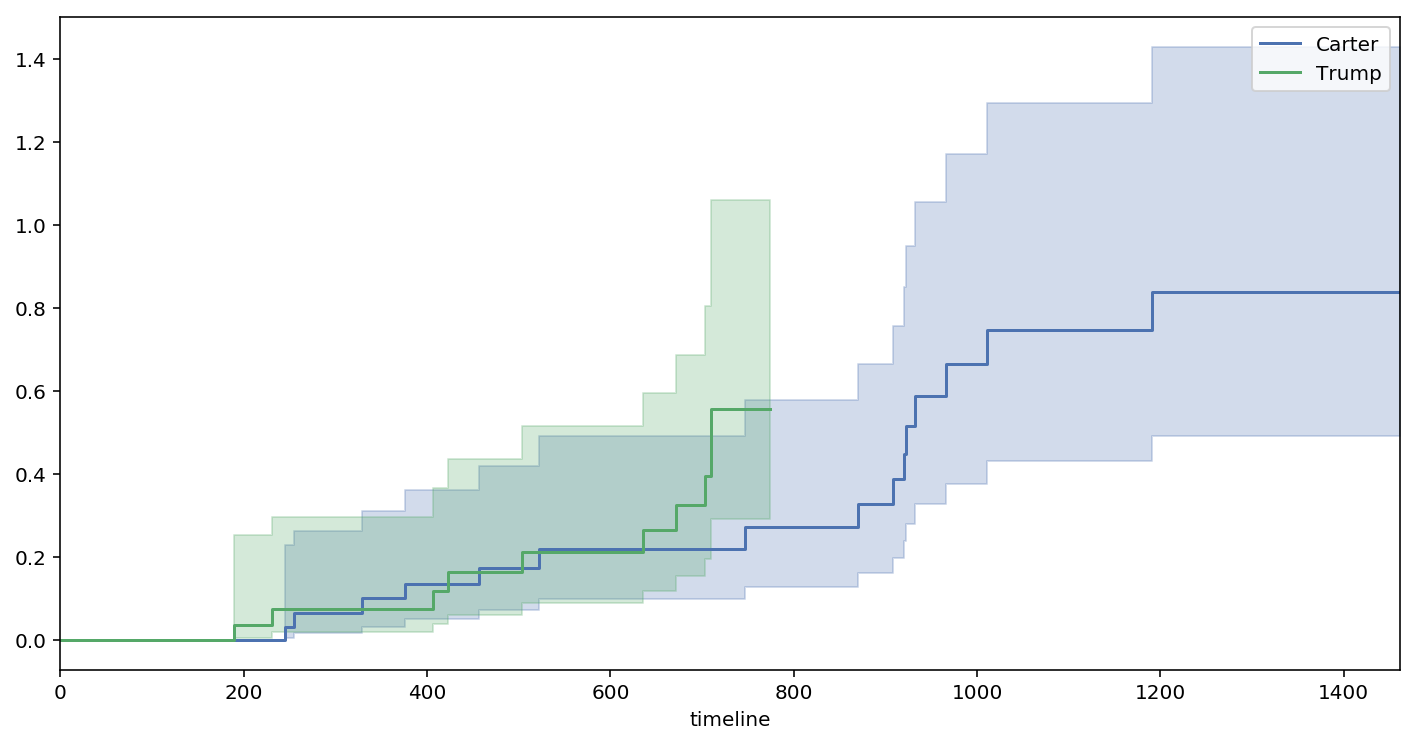

In [10]:
raw_df[['president','event', 'T']]

naf = NelsonAalenFitter()

ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    if name in ['Trump', 'Carter']:
        naf.fit(df_['T'], df_['event'], label=name)
        ax = naf.plot(ax=ax)

In [11]:
raw_df['year'] = raw_df['start'].apply(lambda d: int(d.year))
raw_df['year'] -= raw_df['year'].mean()
raw_df['year**2'] = raw_df['year']**2



regression_df = raw_df[['president', 'T', 'event', 'year', 'year**2']]
regression_df = pd.get_dummies(regression_df, columns=['president'])
del regression_df['president_Clinton']

In [12]:
cph = CoxPHFitter()
cph.fit(regression_df, 'T', 'event')
cph.print_summary(3)

<lifelines.CoxPHFitter: fitted with 287 observations, 129 censored>
      duration col = 'T'
         event col = 'event'
number of subjects = 287
  number of events = 158
    log-likelihood = -724.975
  time fit was run = 2019-03-05 20:03:33 UTC

---
                    coef  exp(coef)  se(coef)      z     p  -log2(p)  lower 0.95  upper 0.95
year               0.110      1.116     0.059  1.870 0.061     4.024      -0.005       0.225
year**2           -0.005      0.995     0.002 -2.092 0.036     4.779      -0.010      -0.000
president_Bush 41  1.449      4.257     0.489  2.962 0.003     8.355       0.490       2.407
president_Bush 43 -0.625      0.535     0.539 -1.160 0.246     2.023      -1.681       0.431
president_Carter   4.600     99.502     1.431  3.215 0.001     9.580       1.795       7.405
president_Obama   -1.074      0.342     1.042 -1.030 0.303     1.723      -3.117       0.969
president_Reagan   2.366     10.658     0.886  2.672 0.008     7.050       0.630       4.102
pres

In [13]:
cph.check_assumptions(regression_df)

Proportional hazard assumption looks okay.


In [15]:
from lifelines import *

wf = WeibullAFTFitter(penalizer=0.0)
wf.fit(regression_df, 'T', 'event')
wf.print_summary(3)

<lifelines.WeibullAFTFitter: fitted with 287 observations, 129 censored>
      duration col = 'T'
         event col = 'event'
number of subjects = 287
  number of events = 158
    log-likelihood = -1319.942
  time fit was run = 2019-03-05 20:03:44 UTC

---
                            coef  exp(coef)  se(coef)      z       p  -log2(p)  lower 0.95  upper 0.95
lambda_ year              -0.031      0.970     0.026 -1.186   0.236     2.085      -0.081       0.020
        year**2            0.003      1.003     0.001  2.190   0.029     5.132       0.000       0.005
        president_Bush 41 -0.525      0.591     0.209 -2.512   0.012     6.379      -0.935      -0.115
        president_Bush 43  0.077      1.080     0.245  0.313   0.754     0.407      -0.404       0.557
        president_Carter  -1.837      0.159     0.629 -2.922   0.003     8.166      -3.069      -0.605
        president_Obama    0.109      1.115     0.474  0.229   0.819     0.289      -0.821       1.038
        president_Rea

In [16]:
lnf = LogNormalAFTFitter(penalizer=0.0000)
lnf.fit(regression_df, 'T', 'event')
lnf.print_summary(3)

<lifelines.LogNormalAFTFitter: fitted with 287 observations, 129 censored>
      duration col = 'T'
         event col = 'event'
number of subjects = 287
  number of events = 158
    log-likelihood = -1328.054
  time fit was run = 2019-03-05 20:03:46 UTC

---
                           coef  exp(coef)  se(coef)      z       p  -log2(p)  lower 0.95  upper 0.95
mu_    year              -0.034      0.966     0.027 -1.268   0.205     2.288      -0.087       0.019
       year**2            0.003      1.003     0.001  1.995   0.046     4.441       0.000       0.005
       president_Bush 41 -0.456      0.634     0.241 -1.891   0.059     4.092      -0.929       0.017
       president_Bush 43  0.221      1.247     0.276  0.801   0.423     1.240      -0.320       0.762
       president_Carter  -1.768      0.171     0.676 -2.616   0.009     6.811      -3.093      -0.443
       president_Obama    0.231      1.260     0.502  0.461   0.645     0.632      -0.753       1.215
       president_Reagan  -

In [17]:
llf = LogLogisticAFTFitter(penalizer=0.000)
llf.fit(regression_df, 'T', 'event')
llf.print_summary(3)

<lifelines.LogLogisticAFTFitter: fitted with 287 observations, 129 censored>
      duration col = 'T'
         event col = 'event'
number of subjects = 287
  number of events = 158
    log-likelihood = -1321.774
  time fit was run = 2019-03-05 20:03:46 UTC

---
                           coef  exp(coef)  se(coef)      z       p  -log2(p)  lower 0.95  upper 0.95
alpha_ year              -0.032      0.969     0.026 -1.234   0.217     2.203      -0.083       0.019
       year**2            0.002      1.002     0.001  2.005   0.045     4.474       0.000       0.005
       president_Bush 41 -0.412      0.662     0.228 -1.804   0.071     3.810      -0.860       0.036
       president_Bush 43  0.183      1.201     0.255  0.719   0.472     1.083      -0.316       0.683
       president_Carter  -1.741      0.175     0.660 -2.636   0.008     6.898      -3.035      -0.447
       president_Obama    0.225      1.252     0.471  0.478   0.633     0.661      -0.697       1.147
       president_Reagan 

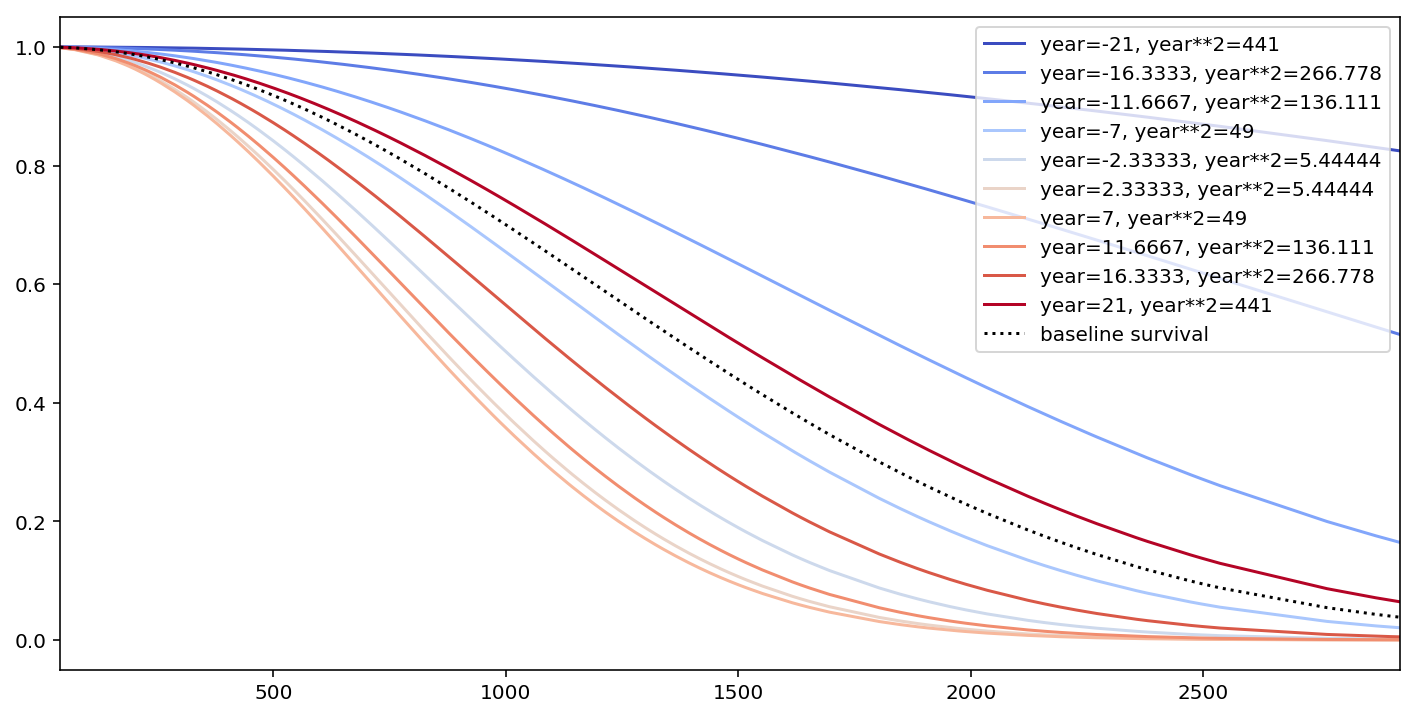

In [18]:
wf.plot_covariate_groups(['year', 'year**2'], values=[[x, x**2] for x in linspace(-21, 21, 10)], cmap='coolwarm')

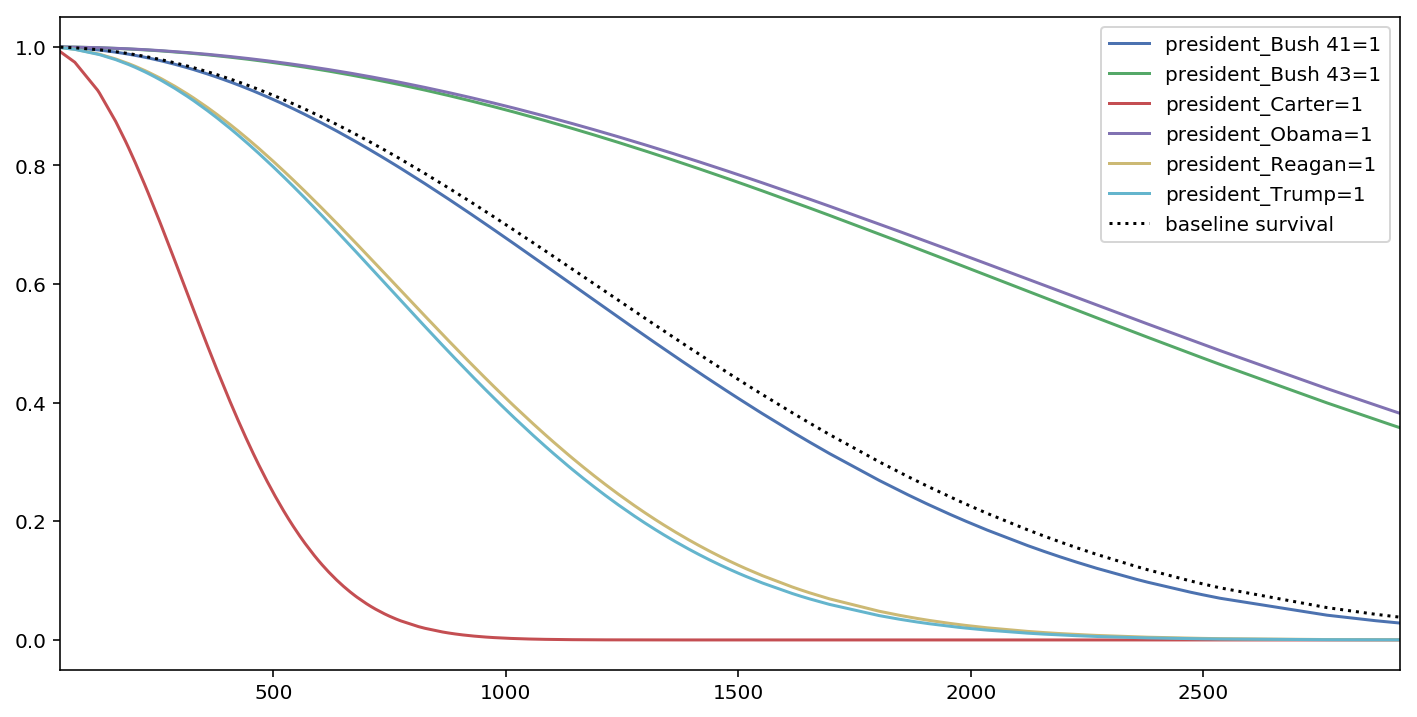

In [19]:
wf.plot_covariate_groups(covariates=regression_df.filter(like='president').columns.tolist(), 
                         values=np.eye(6))